# A Prototype of a Cluster Identification and Classification System

In this notebook I present a prototype of a system that finds a service user's most frequent locations, identifies which of these is his home and then classifies locations as 'home' or 'other'. 

## The System's Broad Architecture

In the first stage the DBSCAN unsupervised learning algorithm is used to cluster the data. Temporal statistics can be used to identify which of the clusters corresponds to his home and which to other locations. For the data I have analyzed the most dense cluster is a good candidate for the home location and I will use this criterion in this prototype. All the clusters are then divided into two categories: 'home' and 'other', i.e. the 'home' cluster is given one label and all the other clusters are grouped together as one and given another label, corresponding to 'other'. The data, with the new labels, is then fed into a supervised learning algorithm that is trained to find the decision boundary that defines the 'home' region in physical space. I propose to use a Support Vector Machine for the classification stage [3]. The SVM is widely prefered as a classifier to a neural network because it is easier to train and works well with moderately sized datasets. Further, it is formulated as a convex optimization problem therefore has a unique solution. The SVM also has theoretically principled foundations in statistical learning theory. In recent years the Random Forest algorithm has started to challenge the SVM and for production systems this should be investigated and its performance compared with that of the SVM. However, the specfic classifier used does not affect the basic architecture proposed in an essential manner,  which is that of an unsupervised learning algorithm to find the clusters which are then fed as the input to a supvervised learning algorithm for classification.

#  Python Implementation

I first use previous code to load, process and display the data for user two.

In [28]:
#Pre-loaded functions
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [29]:
df=pd.read_csv('ds_task_extract.csv',encoding='latin-1')

C:\Users\jamil\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (25,26,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Forming a dataframe with the relevent columns, converting timestamps to dates, and removing points with an error greater than 300m:

In [30]:
data = df[['latitude', 'longitude', 'location_accuracy','timestamp', 'session']]

data.index = data['timestamp']
data = data.drop('timestamp', 1)
data.columns = ['lat', 'long', 'error', 'ID']
data = data.dropna()
data.index = pd.to_datetime(data.index.values, unit='s')
ID2 = data[data['ID'] == '020617FA36714A919789E2CEDF062BB6']
ID2 = ID2[ID2['error'] < 1500]

Preparing the data for display on a map to show where the user is located:

In [31]:
lat2 = ID2['lat'].values
long2 = ID2['long'].values
error2 = ID2['error'].values

C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3310: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3319: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


longitude range 103.93691 104.05683
latitude range 1.041687 1.158209
size of data (793,)


C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


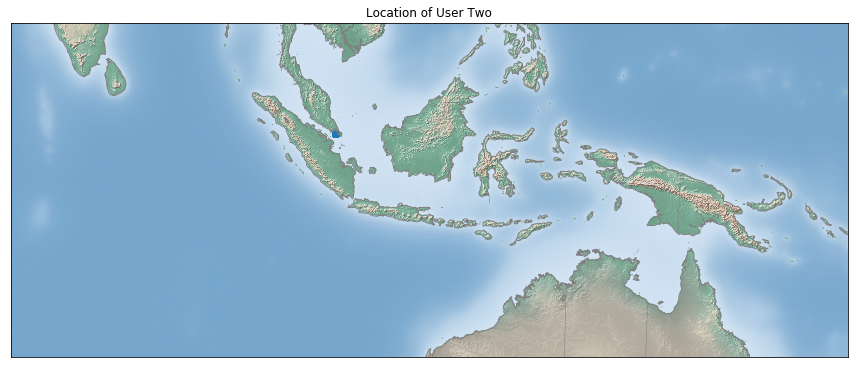

In [32]:
fig = plt.figure(figsize=(15, 15))
map = Basemap(projection='lcc', resolution='l',
lat_0=-5, lon_0=114,
width=1E7, height=4E6)
map.shadedrelief()
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.drawstates(color='gray')

print('longitude range', np.min(long2), np.max(long2))
print('latitude range', np.min(lat2), np.max(lat2))
print('size of data', np.shape(long2))
plt.title('Location of User Two')
map.scatter(long2, lat2, latlon=True)

This service user lives in the Indonesian island-city of Batam near Singapore.

## Cluster Identification

The clusters and their respective densities are identified using the DBSCAN algorith. The epsilon parameter is set to 0.005 which corresponds to distances of around 500m at this latitude. This is the length scale at which I expect to see structure in the clustering. The minimum samples parameter is set to a low figure because of the small size of the dataset.

In [33]:
# converting the lat, long and error columns of the dataframe to a numpy matrix

ID2sorted = ID2
coordinates2 = ID2sorted.as_matrix(columns=[ 'long', 'lat', 'error'])

In [34]:
# Carrying out the clustering
db2 = DBSCAN(eps=0.005, min_samples=3).fit(coordinates2[:,:2])
cluster_labels2 = db2.labels_
unique_labels2 = set(cluster_labels2)

In [35]:
# calculate the number of clusters in labels while ignore the noise (labelled with -1)
num_clusters2 = len(set(cluster_labels2)) - (1 if -1 in cluster_labels2 else 0)
print('The number of clusters found is', num_clusters2)

The number of clusters found is 6


I now display the data with the clusterings found by the DBSCAN algorithm.

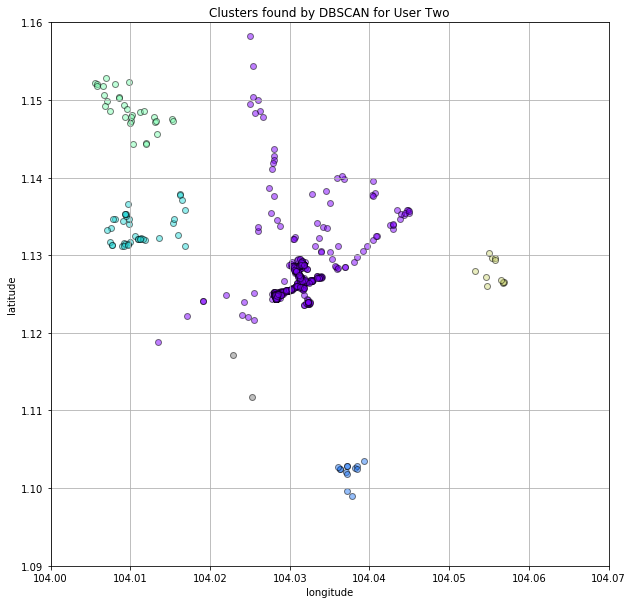

In [36]:
# get colors and plot all the points color-coded by cluster or in gray if it is noise
fig, ax = plt.subplots(figsize=[10,10])
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels2)))

# for each cluster label and color, plot the cluster's points
for cluster_label, color in zip(unique_labels2, colors):
    
    size = 150
    if cluster_label == -1: # the noise appears as small grey points
        color = 'gray'
        size = 30
    
    # plot the points that match the current cluster label
    x_coords2 = coordinates2[cluster_labels2==cluster_label][:,0]
    y_coords2 = coordinates2[cluster_labels2==cluster_label][:,1]
    error_rad2 = coordinates2[cluster_labels2==cluster_label][:,2]
    ax.scatter(x=x_coords2, y=y_coords2, c=color, edgecolor='k', alpha=0.5)

    
ax.set_title('Number of clusters: {}'.format(num_clusters2))

plt.title('Clusters found by DBSCAN for User Two')
plt.ylim(1.09, 1.16)
plt.xlim(104, 104.07)
np.shape(colors)
ax.grid()
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

## SVM Training

Next I train an SVM to find a decision boundary that will delineate the region on the map considered to be the user's home and seperate it from all other locations. First the data needs to put in a suitable form for scikit-learn's machine learning routines. I am indentifying the largest and most dense cluster as 'home'.

In [37]:
# determine and print out the unique clusters found by DBSCAN and their respective frequencies

un2 = np.unique(cluster_labels2, return_counts = True)
un2 #

(array([-1,  0,  1,  2,  3,  4,  5], dtype=int64),
 array([  8, 688,  13,  39,  31,  11,   3], dtype=int64))

DVSCAN has found 6 clusters. the largest I label as 'home' and all other clusters as 'other'. 

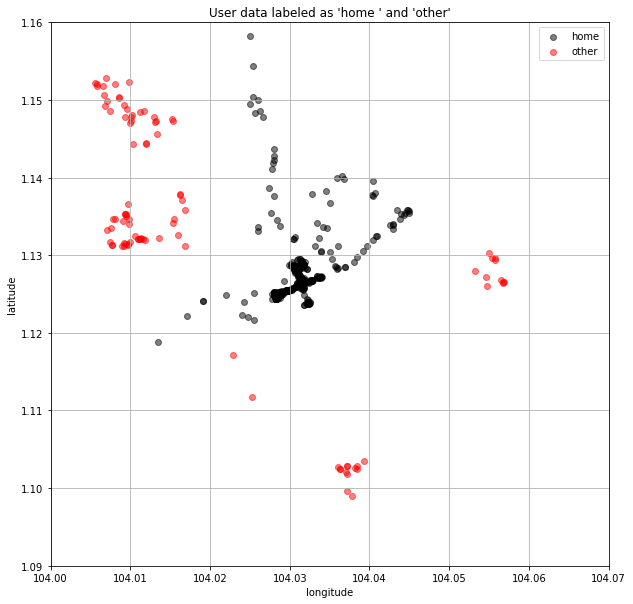

In [38]:
home_label2 = np.argmax(un2[1]) - 1
test2 = cluster_labels2 == home_label2

homelength2 = np.sum(test2)

home_coords2 = np.zeros((homelength2, 2))
home_coords2 = coordinates2[test2][:,:2]


othertest2 = cluster_labels2 != home_label2
otherlength2 = np.sum((cluster_labels2 != home_label2))

other_coords2 = np.zeros((otherlength2,2))
other_coords2 = coordinates2[cluster_labels2 != home_label2][:,:2]


fig, ax = plt.subplots(figsize=[10,10])
ax.scatter(home_coords2[:,0], home_coords2[:,1], color = 'k', alpha=0.5, label ='home')
ax.scatter(other_coords2[:,0], other_coords2[:,1], color = 'r', alpha=0.5, label ='other')
plt.legend()
plt.title('User data labeled as \'home \' and \'other\'')
plt.ylim(1.09, 1.16)
plt.xlim(104, 104.07)
ax.grid()
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

I train the SVM with the above data.

In [39]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [40]:
# build the target vector for scikit-learn's SVM function
hometarget = np.zeros((homelength2,1))
othertarget = np.ones((otherlength2,1))


# form the input and target arrys for scikit-learn

X = np.concatenate([ home_coords2, other_coords2], 0)
y = np.concatenate([hometarget, othertarget], 0)
y = np.ravel(y)

# there is a two order of magnitude difference between lat and long
# thefore for good performance scaling is needed

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)



# Several varients of SVM were investiaged, display results for one
# Hardcoded parameter values found by trial and error 

C = 7.7*10**-1
#clf = svm.SVC(kernel='poly', degree=5, C=C)
#clf = svm.NuSVC(0.1,kernel='rbf', gamma=10**1, class_weight={1: 7.7} )

# the data set is highly imbalanced therefore the class_weight has to be set
clf = svm.SVC(kernel='rbf', gamma=10**1, C=C, class_weight={1: 7.7} )
clf.fit(X_scaled,y)

#clf = svm.OneClassSVM(nu=1, kernel="rbf", gamma=10**1)
#clf.fit(X_scaled,y)

SVC(C=0.77, cache_size=200, class_weight={1: 7.7}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Use a Radial Basis Function as the kernel of the SVM. For a production system the parameters $\gamma$ and $C$ should be found in a more rigourous manner than the heuristic approach used here, but this suffices for my purposes. Displaying the decision boundary found by the SVM:

(104, 104.07)

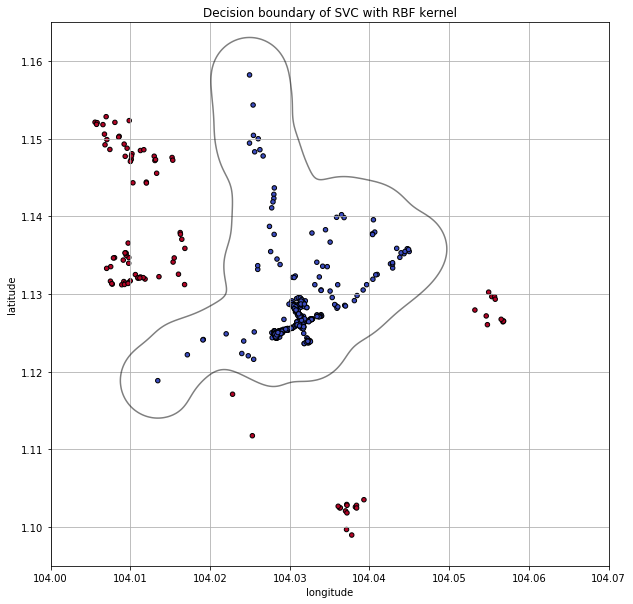

In [41]:
# determine sVC decision boundry for scaled data
X0, X1 = X_scaled[:, 0], X_scaled[:, 1]
xx, yy = make_meshgrid(X0, X1)
xy = np.vstack([xx.ravel(), yy.ravel()]).T
Z = clf.decision_function((xy)).reshape(xx.shape)


# invert the scaling on the grid points so decision boundary
# can be displayed with original coordinates
xy_rescaled = np.squeeze(np.vsplit(scaler.inverse_transform(xy).T, 1))
xx_rescaled = xy_rescaled[0,:]
yy_rescaled = xy_rescaled[1,:]

xx_rescaled = xx_rescaled.reshape(xx.shape)
yy_rescaled = yy_rescaled.reshape(yy.shape)

# invert the scaling an the data 
# (do this instead of using orignal data as a check)
X0_rescaled = scaler.inverse_transform(X_scaled)[:,0]
X1_rescaled = scaler.inverse_transform(X_scaled)[:,1]


fig, ax = plt.subplots(figsize=[10,10])
a = ax.contour(xx_rescaled, yy_rescaled, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
ax.scatter(X0_rescaled, X1_rescaled, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], s=500)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
title = 'Decision boundary of SVC with RBF kernel'
ax.set_title(title)
ax.grid()
plt.ylim(1.095, 1.165)
plt.xlim(104, 104.07)

Computing the score, which is a measure of the efficacy of the classifier. For a production system we would undertake a  rigourous assessment by employing a gridsearch over a range of parameters to find the optimal parameter set and we would use a seperate test dataset to compute the score:

In [42]:
print(clf.score(X_scaled, y))

1.0


## SVM Classification

Try some test coordinates to see whether they are classified as 'home' (0) or 'other' (1):

In [43]:
pred = clf.predict(scaler.transform([[104.01, 1.12], [104.03, 1.11], [ 104.029, 1.135], [104.04, 1.13 ], [104.042,1.155]]))
pred

array([ 0.,  1.,  0.,  0.,  1.])

The  second and last test locations are classified as 'other' while the remaining three are classified as 'home'. Displaying the test data:

(104, 104.071)

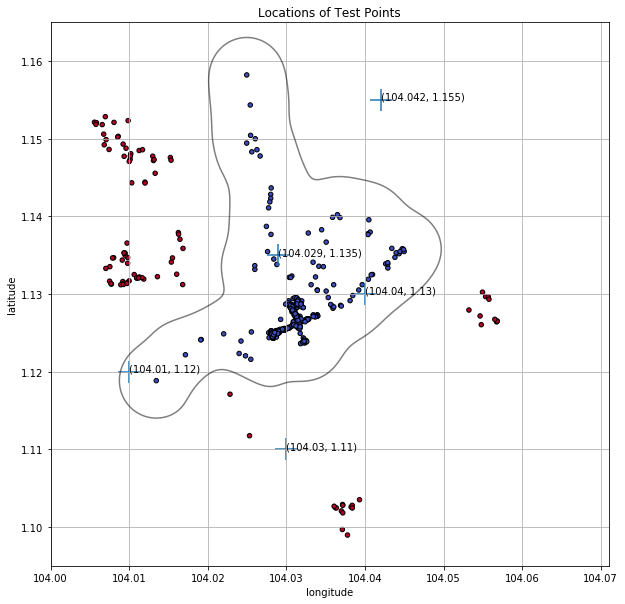

In [44]:
fig, ax = plt.subplots(figsize=[10,10])
a = ax.contour(xx_rescaled, yy_rescaled, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
ax.scatter(X0_rescaled, X1_rescaled, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')


# test coordinates
long_c = [104.01, 104.03, 104.029, 104.04, 104.042]
lat_c  = [1.12, 1.11, 1.135, 1.13, 1.155]
ax.scatter(long_c, lat_c, s =450, marker = '+')

# label the test coordinates
for xy in zip(long_c, lat_c):                           
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') 

title = 'Locations of Test Points'
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title(title)
ax.grid()
plt.ylim(1.095, 1.165)
plt.xlim(104, 104.071)

(Note:the latitude and longitude coordinates are in reverse order)

# Conclusion

I have presented a prototype to illustrate a system that finds user's frequent locations from data, identities the home location, and finally trains a classifer to determine whether a location is the user's home or another location. The system architecture is that  of a pipeline consisting of an unsupervised and a supervised learning algorithm in series, with the output of the former acting as the input of the latter. The clustering is achieved through the DBSCAN algorithim; the cluster corresponding to the home location  is identified as the largest cluster; and finally an SVM is trained on the data thus labelled to predict the status of any location.

# Bibliography

1. Spatio-Temporal Clustering: a Survey by Kisilevich et al. Data Mining and Knowledge discovery Handbook. Springer
3. Pattern Recognition and Machine Learning by Christopher Bishop